In [2]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import statsmodels.api as sm
from scipy.stats import chisquare
import scipy
import re

In [3]:
# Lecture des fichiers csv.
df_csts = pd.read_csv('customers.csv', sep=',')
df_prod= pd.read_csv('products.csv', sep=',')
df_trans= pd.read_csv('transactions.csv', sep=',')

In [4]:
def format_col(value_column, valid_format):
    found = re.search(valid_format, value_column)
    if found is None:
        print('{} doest not match format.'.format(value_column))
        return np.nan
    else:
        return value_column

# Mission n°1

# Jointure avec la table d'association pour repérer les erreurs

In [5]:
df_joint1=pd.merge(df_trans,df_prod,on='id_prod', how = "right")
df_joint2=pd.merge(df_trans,df_csts,on='client_id',  how = "right")

In [6]:
# on remarque que certains produits sont dans la table transactions mais pas dans produits > erreur fiche produit
df_joint1.isnull().any()

id_prod       False
date           True
session_id     True
client_id      True
price         False
categ         False
dtype: bool

In [7]:
# certains clients sont dans la base de données de clients mais n'ont pas fait de transactions
df_joint2.isnull().any()

id_prod        True
date           True
session_id     True
client_id     False
sex           False
birth         False
dtype: bool

In [8]:
df_joint=pd.merge(df_csts,df_trans,on='client_id', how='left')
df_joint=pd.merge(df_joint,df_prod,on='id_prod',how='left')
df_joint.head()

,client_id,sex,birth,id_prod,date,session_id,price,categ
0,c_4410,f,1967,0_1455,2021-03-22 14:29:25.189266,s_9942,8.99,0.0
1,c_4410,f,1967,0_1376,2021-09-24 22:58:27.418343,s_94984,16.24,0.0
2,c_4410,f,1967,1_312,2022-01-29 14:07:47.482092,s_156960,24.56,1.0
3,c_4410,f,1967,1_653,2021-07-29 23:34:41.866951,s_68860,25.99,1.0
4,c_4410,f,1967,0_1110,2021-11-04 16:28:30.169021,s_114715,4.71,0.0


In [9]:
df_joint.isnull().any()

client_id     False
sex           False
birth         False
id_prod        True
date           True
session_id     True
price          True
categ          True
dtype: bool

In [10]:
# On identifie les clients qui n'ont pas fait de transactions
df_csts.loc[~df_csts["client_id"].isin(df_joint["client_id"])].count()
# Ils sont 21, sur une base totale de 8623, soit moins de 0,2% du total

client_id    0
sex          0
birth        0
dtype: int64

In [11]:
# On identifie les produits qui n'ont pas été vendu
df_prod.loc[~df_prod["id_prod"].isin(df_joint["id_prod"])].count()
# Ils sont 22, sur une base totale de 8623, soit moins de 0,2% du total

id_prod    22
price      22
categ      22
dtype: int64

In [12]:
# on identifie les produits qui ont fait l'objet de transaction mais ne sont pas dans la table products
df_trans.loc[~df_trans["id_prod"].isin(df_prod["id_prod"])].head()
# id_prod '0_2245' pas dans 'products'

,id_prod,date,session_id,client_id
6235,0_2245,2021-06-17 03:03:12.668129,s_49705,c_1533
10802,0_2245,2021-06-16 05:53:01.627491,s_49323,c_7954
14051,0_2245,2021-11-24 17:35:59.911427,s_124474,c_5120
17486,0_2245,2022-02-28 18:08:49.875709,s_172304,c_4964
21078,0_2245,2021-03-01 00:09:29.301897,s_3,c_580


In [13]:
# on cherche le prix moyen d'un produit de catégorie 0 pour l'attribuer à ce pro
mean_categ_0 = round(np.mean(df_prod["price"][df_prod["categ"] == 0]), 2)
mean_categ_0

11.73

In [14]:
# On rajoute ce produit à la table df_prod.
zero = np.int(0)
df_prod.loc[-1, :] = ["0_2245", mean_categ_0, zero]
df_prod["categ"] = df_prod["categ"].astype(int)
df_prod.reset_index(drop=True, inplace=True)

# Table products

In [15]:
df_prod.head()

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0


In [16]:
# On check des valeurs manquantes ou abbérantes
df_prod.isnull().any()

id_prod    False
price      False
categ      False
dtype: bool

In [17]:
# On voit qu'il y a un prix négatif
df_prod.sort_values(by=['price'],ascending='false').head()

,id_prod,price,categ
731,T_0,-1.00,0
2355,0_202,0.62,0
2272,0_528,0.62,0
370,0_120,0.66,0
1211,0_1844,0.77,0


In [18]:
# On supprime celle ligne, cela aurait pu être une erreur mais l'id Prod est
# différent des autres produits, le T fait probablement référence à test
df_prod = df_prod[df_prod['price'] > 0]
df_prod.reset_index(inplace=True, drop=True) # On reset l'index pour prendre en compte les lignes éliminées.

In [19]:
# On check si d'autres id sont aberrants 'id_prod'.
df_prod["id_prod"] = [format_col(
    value_id_prod, '^[0,1,2]_[0-9]+$') for value_id_prod in df_prod["id_prod"]]
# Pas de retour donc ce produit était le seul à avoir un format aberrant.

In [20]:
# On check si le premier chiffre de l'id correspond à la catégorie
check_idp=pd.DataFrame(df_prod.loc[:, "id_prod"].str[0].astype(
    int) == df_prod.loc[:, "categ"],columns=['check'])
check_idp=check_idp[check_idp['check'] == False]
check_idp
# Pas de retour donc bonne cohérence ici

,check


In [21]:
# on vérifie qu'il n'y a pas de dupliqués
df_prod.duplicated(subset=["id_prod"]).any()

False

In [22]:
df_prod.head()

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0


# Table customers

In [23]:
df_csts.head()

,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984
3,c_5961,f,1962
4,c_5320,m,1943


In [24]:
df_csts["client_id"] = [format_col(
    value_client_id, "^c_[0-9]{0,5}$") for value_client_id in df_csts["client_id"]]

ct_0 doest not match format.
ct_1 doest not match format.


In [25]:
# on regarde dans la table transactions si ces ID sont liés à notre produit T_0...
df_test=df_trans[(df_trans['id_prod']=='T_0')]
df_test.head()

,id_prod,date,session_id,client_id
1431,T_0,test_2021-03-01 02:30:02.237420,s_0,ct_1
2365,T_0,test_2021-03-01 02:30:02.237446,s_0,ct_1
2895,T_0,test_2021-03-01 02:30:02.237414,s_0,ct_1
5955,T_0,test_2021-03-01 02:30:02.237441,s_0,ct_0
7283,T_0,test_2021-03-01 02:30:02.237434,s_0,ct_1


In [26]:
# on supprime ces clients qui sont liés au produit id T_0
df_csts.dropna(inplace=True, how='any')

In [27]:
# On enlève les deux premiers caractères c_ qui se répètent et nuisent à une bonne visibilité
df_csts['client_id'] = df_csts['client_id'].str[2:]

In [28]:
# On check s'il y a des valeurs manquantes
df_csts.isnull().any()

client_id    False
sex          False
birth        False
dtype: bool

{'whiskers': [<matplotlib.lines.Line2D at 0x1c10006860>,
 'caps': [<matplotlib.lines.Line2D at 0x1c1001c160>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c10006710>],
 'medians': [<matplotlib.lines.Line2D at 0x1c1001c9b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c1001cdd8>],
 'means': []}

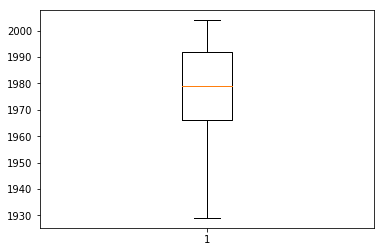

In [29]:
# On check s'il y a des valeurs aberrantes
plt.boxplot(df_csts.birth)

In [30]:
# On check s'il y a des valeurs aberrantes
df_csts.sex.unique()

array(['f', 'm'], dtype=object)

In [31]:
# on vérifie qu'il n'y a pas de dupliqués
df_csts.duplicated(subset=["client_id"]).any()

False

In [32]:
# on ajoute la colonne age
df_csts['age'] = -df_csts['birth']+2022

In [33]:
# Csts est clean
df_csts.head()

,client_id,sex,birth,age
0,4410,f,1967,55
1,7839,f,1975,47
2,1699,f,1984,38
3,5961,f,1962,60
4,5320,m,1943,79


# Table transactions

In [34]:
df_trans.head()

,id_prod,date,session_id,client_id
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450
1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277
2,1_374,2021-09-23 15:13:46.938559,s_94290,c_4270
3,0_2186,2021-10-17 03:27:18.783634,s_105936,c_4597
4,0_1351,2021-07-17 20:34:25.800563,s_63642,c_1242


In [35]:
# On enlève donc toutes les lignes où il y a T_0
df_trans=df_trans[(df_trans['id_prod']!='T_0')]
df_trans.head()

,id_prod,date,session_id,client_id
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450
1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277
2,1_374,2021-09-23 15:13:46.938559,s_94290,c_4270
3,0_2186,2021-10-17 03:27:18.783634,s_105936,c_4597
4,0_1351,2021-07-17 20:34:25.800563,s_63642,c_1242


In [36]:
# On enlève les deux premiers caractères c_ qui se répètent et nuisent à une bonne visibilité
df_trans['session_id'] = df_trans['session_id'].str[2:]
df_trans['client_id'] = df_trans['client_id'].str[2:]

In [37]:
# On sépare la colonne date entre la date (jour) et l'heure de la commande
df_trans[['date','hour']] = df_trans['date'].str.split(' ',expand=True)
df_trans.head()

,id_prod,date,session_id,client_id,hour
0,0_1483,2021-04-10,18746,4450,18:37:28.723910
1,2_226,2022-02-03,159142,277,01:55:53.276402
2,1_374,2021-09-23,94290,4270,15:13:46.938559
3,0_2186,2021-10-17,105936,4597,03:27:18.783634
4,0_1351,2021-07-17,63642,1242,20:34:25.800563


In [38]:
# On enlève le millionème de seconde
df_trans['hour'] = df_trans['hour'].str[:-7]

In [39]:
# On extrait l'année pour créer des tendances
df_trans['year'] = df_trans['date'].str[:-6]

In [40]:
# On extrait l'année pour créer des tendances
df_trans['month'] = df_trans['date'].str[5:-3]

In [41]:
# On checke des valeurs manquantes 
df_trans.isnull().any()

id_prod       False
date          False
session_id    False
client_id     False
hour          False
year          False
month         False
dtype: bool

In [42]:
df_trans.head()

,id_prod,date,session_id,client_id,hour,year,month
0,0_1483,2021-04-10,18746,4450,18:37:28,2021,04
1,2_226,2022-02-03,159142,277,01:55:53,2022,02
2,1_374,2021-09-23,94290,4270,15:13:46,2021,09
3,0_2186,2021-10-17,105936,4597,03:27:18,2021,10
4,0_1351,2021-07-17,63642,1242,20:34:25,2021,07


# Mission N°2

# Analyses de la démographie

In [43]:
# Age des clients
df_age=df_csts.groupby(['age']).count().reset_index()
df_age=df_age.drop(columns=['birth','sex'])
df_age.rename(columns={'client_id':'count'}, inplace=True)
df_age.head()

,age,count
0,18,440
1,19,146
2,20,146
3,21,127
4,22,136


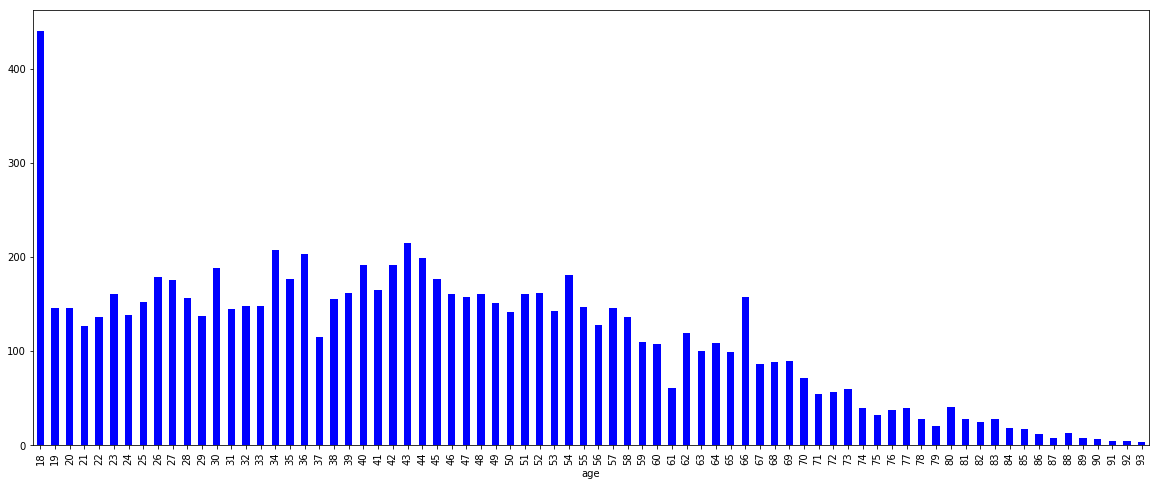

In [44]:
Age=df_age.plot(x='age', y='count',kind='bar',figsize=(20,8), legend=False, color='blue')

In [45]:
df_sex=df_csts.groupby(['sex']).count().reset_index()
df_sex=df_sex.drop(columns=['birth','age'])
df_sex.rename(columns={'client_id':'count'}, inplace=True)
df_sex

,sex,count
0,f,4490
1,m,4131


# Revenus totaux par catégorie de produits sur l'ensemble de la période

In [46]:
# On crée une table des revenues via merge les tables de produits et de transaction afin d'obtenir les ventes
df_revenues=pd.merge(df_prod,df_trans,on='id_prod')
df_revenues.head()

,id_prod,price,categ,date,session_id,client_id,hour,year,month
0,0_1421,19.99,0,2021-05-12,33709,7954,23:26:29,2021,05
1,0_1421,19.99,0,2022-01-25,154957,254,11:27:39,2022,01
2,0_1421,19.99,0,2022-01-02,144068,5770,22:29:33,2022,01
3,0_1421,19.99,0,2021-03-05,2187,1455,17:10:40,2021,03
4,0_1421,19.99,0,2021-03-29,13112,2768,13:55:04,2021,03


In [47]:
# Revenues par produits
df_revbyprod=df_revenues.groupby(['id_prod','categ','year'])['price'].sum().reset_index()
df_revbyprod.rename(columns={'price':'revenues'}, inplace=True)
df_revbyprod.head()

,id_prod,categ,year,revenues
0,0_0,0,2021,1972.50
1,0_0,0,2022,318.75
2,0_1,0,2021,2274.93
3,0_1,0,2022,461.58
4,0_10,0,2021,197.45


In [48]:
# Revenues par année
df_revbyear=df_revenues.groupby(['year'])['price'].sum().reset_index()
df_revbyear.rename(columns={'price':'revenues'}, inplace=True)
df_revbyear.head()
# Ajouter histogramme

,year,revenues
0,2021,4.741902e+06
1,2022,1.055884e+06


In [49]:
# Revenues par catégorie
df_revbycat=df_revenues.groupby(['categ'])['price'].sum().reset_index()
df_revbycat.rename(columns={'price':'revenues'}, inplace=True)
df_revbycat

,categ,revenues
0,0,2.230931e+06
1,1,2.247384e+06
2,2,1.319471e+06


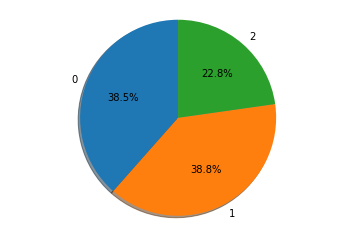

In [50]:
labels = df_revbycat['categ']
sizes = df_revbycat['revenues']
explode = (0, 0, 0) 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 

plt.show()

In [51]:
# transactions par catégorie
df_revbycatt=df_revenues.groupby(['categ']).count().reset_index()
df_revbycatt=df_revbycatt.drop(columns=['price','date','session_id','client_id','month','hour','year'])
df_revbycatt.rename(columns={'id_prod':'count'}, inplace=True)
df_revbycatt['%']=round(df_revbycatt['count']/df_revbycatt['count'].sum()*100, 0)
df_revbycatt

,categ,count,%
0,0,209529,62.0
1,1,109735,33.0
2,2,17552,5.0


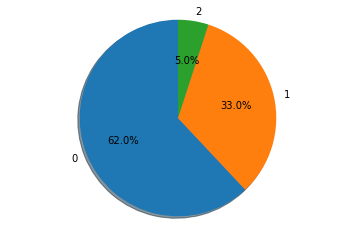

In [52]:
labels = df_revbycatt['categ']
sizes = df_revbycatt['%']
explode = (0, 0, 0) 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 

plt.show()

# Tendances centrales et de dispersions des achats par client

In [53]:
# On regroupe les ventes par client_id
df_revbyclient=df_revenues.groupby(['client_id'])['price'].sum().reset_index()
df_revbyclient.rename(columns={'price':'expenses'}, inplace=True)
df_revbyclient.head()

,client_id,expenses
0,1,300.65
1,10,586.18
2,100,222.87
3,1000,980.02
4,1001,1102.45


In [54]:
max_revbyclient=df_revbyclient.max()
min_revbyclient=df_revbyclient.min()
mean_revbyclient=df_revbyclient.mean()
median_revbyclient=df_revbyclient.median()
var_revbyclient=df_revbyclient.var()
quant_revbyclient=df_revbyclient.quantile(([0.25,0.5,0.75]))

# Ajouter le min, le max, les quantiles (1er qui représente avant 25% et 3eme qui represénte 75% et le reste)

print(max_revbyclient)
print(min_revbyclient)
print(mean_revbyclient)
print(median_revbyclient)
print(var_revbyclient)
print(quant_revbyclient)

client_id       999.00
expenses     162007.34
dtype: float64
client_id    1.00
expenses     4.15
dtype: float64
client_id           inf
expenses     674.161158
dtype: float64
client_id    4310.500
expenses      501.345
dtype: float64
expenses    6.584367e+06
dtype: float64
      expenses
0.25  275.7650
0.50  501.3450
0.75  870.8975


In [55]:
df_revbyclient.sort_values(by=['expenses']).head()

,client_id,expenses
7918,8140,4.15
7889,8114,4.99
750,1675,5.57
8480,890,6.08
8151,8351,6.31


# Courbe de Lorenz : % des dépenses selon % client

In [56]:
df_revbyclient.sort_values(by=['expenses']).head()

,client_id,expenses
7918,8140,4.15
7889,8114,4.99
750,1675,5.57
8480,890,6.08
8151,8351,6.31


In [57]:
revbyclient_lorenz = df_revbyclient.sort_values(by=['expenses']).expenses.cumsum() / df_revbyclient.sort_values(by=['expenses']).expenses.sum()

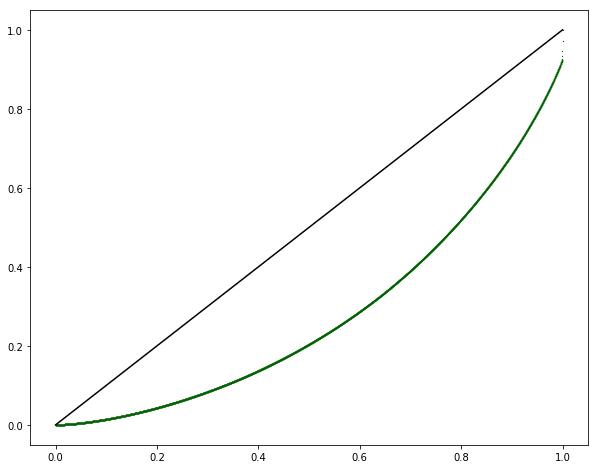

In [58]:
fig, ax = plt.subplots(figsize=[10,8])
## scatter plot of Lorenz curve
ax.scatter(np.arange(revbyclient_lorenz.size)/(revbyclient_lorenz.size-1), revbyclient_lorenz, 
           marker='x', color='darkgreen', s=0.1)
## line plot of equality
ax.plot([0,1], [0,1], color='k')

In [59]:
def gini(list_of_values):
    sorted_list = sorted(list_of_values)
    height, area = 0, 0
    for value in sorted_list:
        height += value
        area += height - value / 2.
    fair_area = height * len(list_of_values) / 2.
    return (fair_area - area) / fair_area

In [60]:
gini(df_revbyclient['expenses'])

0.4397174885499565

In [61]:
df_revbyclient.sort_values(by=['expenses']).tail(4)

,client_id,expenses
2724,3454,54466.38
6337,6714,73220.80
4388,4958,144257.21
677,1609,162007.34


# Graphique du nombre de transactions par jour sur la période

In [62]:
df_transactions = df_revenues['date'].value_counts() # on crée une liste avec le nombre de transactions par date 
df_transactions = pd.DataFrame(df_transactions) # on en fait une df
df_transactions.rename(columns={'date':'transactions'},inplace=True) # on met le bon nom de colonne
df_transactions = df_transactions.reset_index()
df_transactions.rename(columns={'index':'date'}, inplace=True) # on sort les dates de l'index
df_transactions = df_transactions.sort_values(by=['date']) # on ordonne par date
df_transactions.date=pd.to_datetime(df_transactions.date,format="%Y-%m-%d") # on met en format date
df_transactions.head()

,date,transactions
122,2021-03-01,961
159,2021-03-02,938
221,2021-03-03,905
229,2021-03-04,901
157,2021-03-05,939


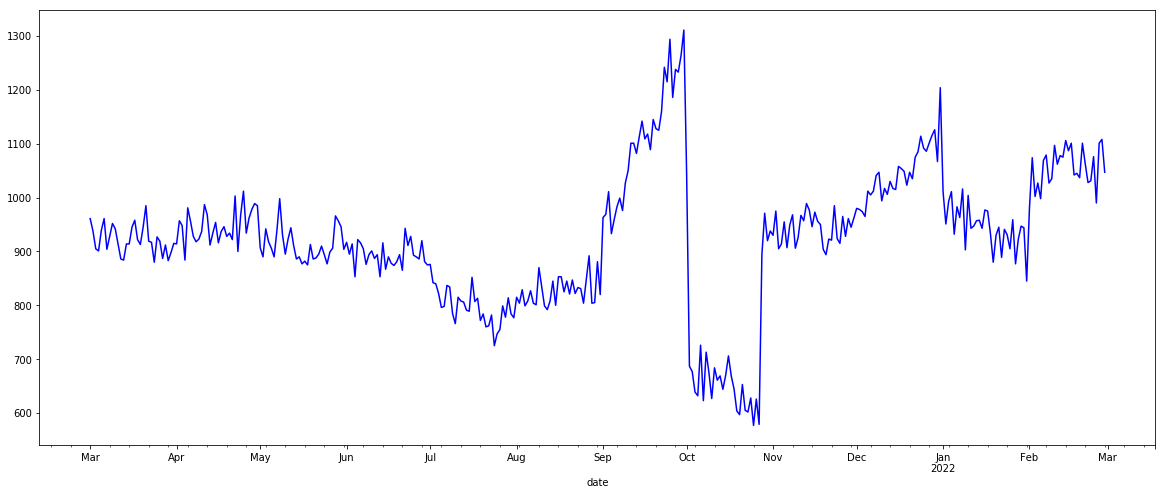

In [63]:
# Série temporelle du nombre de transactions par jour = courbe qui n'est pas stationnaire, on parle d'irrégularité, on détecte le phénomène de saisonnalité
Graph_trans21=df_transactions.plot(x='date', y='transactions',kind='line',figsize=(20,8), legend=False, color='blue')

In [64]:
df_oct=df_revenues[df_revenues['month']=='10']
df_oct=df_oct.groupby(['date','categ'])['price'].sum().reset_index()
df_oct=df_oct.pivot_table(index='date', columns='categ', values='price', fill_value=0)
df_oct.reset_index()
# Pas de ventes de la catégorie 1, on imagine une rupture de stock / mauvaise gestion de stocks

categ,date,0,1,2
0,2021-10-01,6947.51,7003.79,2958.06
1,2021-10-02,7138.02,0.00,1895.13
2,2021-10-03,6783.58,0.00,2060.49
3,2021-10-04,6554.07,0.00,2600.09
4,2021-10-05,6357.91,0.00,3032.55
5,2021-10-06,7543.59,0.00,1798.12
6,2021-10-07,6404.01,0.00,1787.07
7,2021-10-08,7069.53,0.00,3137.82
8,2021-10-09,6808.69,0.00,2616.67
9,2021-10-10,6487.99,0.00,2188.68


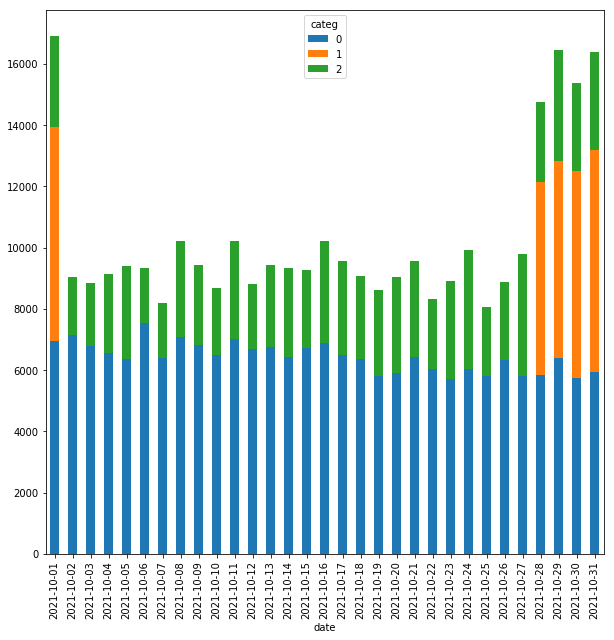

In [65]:
df_oct.plot(kind="bar",figsize=(10,10),stacked=True)

# Histogramme du montant de panier pour chaque session

In [66]:
df_panier=df_revenues.groupby(['session_id'])['price'].sum().reset_index()
df_panier.rename(columns={'price':'prix du panier acheté'}, inplace=True)
df_panier.head()

,session_id,prix du panier acheté
0,1,11.99
1,10,26.99
2,100,33.72
3,1000,39.22
4,10000,41.49


In [67]:
df_panier['prix du panier acheté'].mean()

34.26708961314813

In [68]:
df_panier['prix du panier acheté'].max()

539.23

In [69]:
df_panier['prix du panier acheté'].min()

0.62

In [70]:
df_panier['prix du panier acheté'].var()

1015.8457974529198

In [71]:
df_panier['prix du panier acheté'].quantile(([0.25,0.5,0.75]))

0.25    15.20
0.50    25.57
0.75    42.98
Name: prix du panier acheté, dtype: float64

/Users/eddoha/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


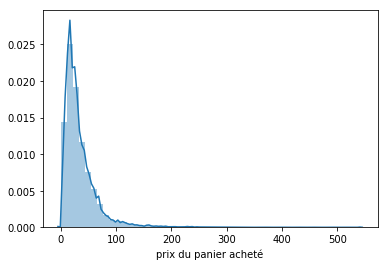

In [72]:
sns.distplot(df_panier['prix du panier acheté'])

# Graphique du revenu total par jour

In [73]:
df_revenues21=df_revenues[(df_revenues['year']=='2021')]
df_revenues21=df_revenues21.groupby(['date'])['price'].sum().reset_index()
df_revenues21.rename(columns={'price':'revenues'}, inplace=True) # on change le nom pour la bonne colonne
df_revenues21.date=pd.to_datetime(df_revenues21.date,format="%Y-%m-%d") # on met en format date
df_revenues21.head()

,date,revenues
0,2021-03-01,16427.97
1,2021-03-02,15349.20
2,2021-03-03,14751.75
3,2021-03-04,15047.09
4,2021-03-05,17173.41


In [74]:
df_totrevenues=df_revenues.groupby(['date'])['price'].sum().reset_index()
df_totrevenues.rename(columns={'price':'revenues'}, inplace=True) # on change le nom pour la bonne colonne
df_totrevenues.date=pd.to_datetime(df_totrevenues.date,format="%Y-%m-%d") # on met en format date
df_totrevenues.head()

,date,revenues
0,2021-03-01,16427.97
1,2021-03-02,15349.20
2,2021-03-03,14751.75
3,2021-03-04,15047.09
4,2021-03-05,17173.41


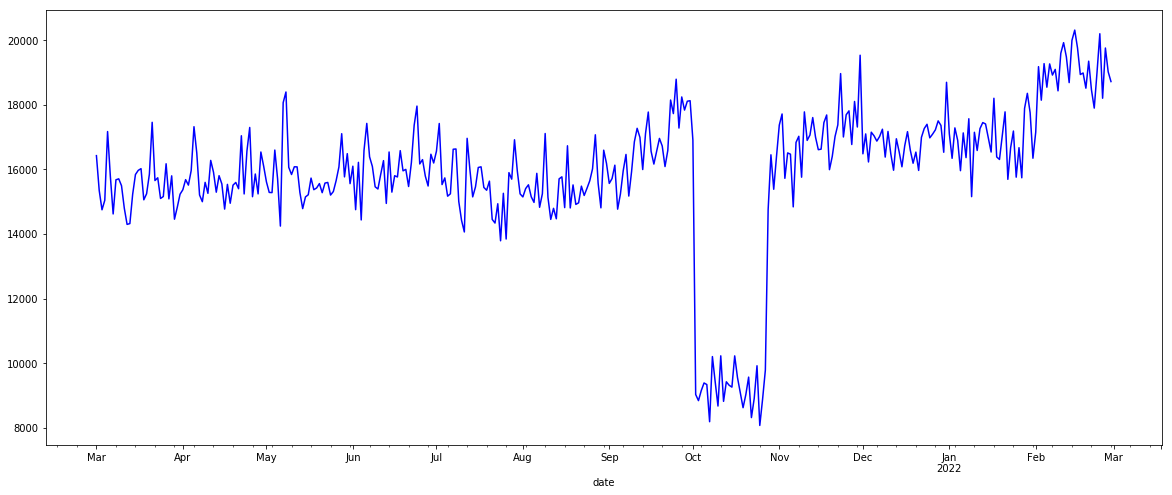

In [75]:
Graph_totrevenues=df_totrevenues.plot(x='date', y='revenues',kind='line',figsize=(20,8), legend=False, color='blue')

# Dépenses selon le sexe

In [76]:
# On crée une nouvelle table via celle des revenues pour y ajouter les infos clients
df_revenues_c=pd.merge(df_revenues,df_csts,on='client_id')
df_revenues_c.head()

,id_prod,price,categ,date,session_id,client_id,hour,year,month,sex,birth,age
0,0_1421,19.99,0,2021-05-12,33709,7954,23:26:29,2021,05,m,1973,49
1,0_1142,3.42,0,2021-03-24,10590,7954,00:54:59,2021,03,m,1973,49
2,0_1446,8.09,0,2021-11-26,125461,7954,18:04:33,2021,11,m,1973,49
3,0_2291,12.99,0,2021-05-29,41299,7954,18:25:02,2021,05,m,1973,49
4,1_385,25.99,1,2021-06-01,42731,7954,20:41:40,2021,06,m,1973,49


In [77]:
df_revbysexe=df_revenues_c.groupby(['sex','categ'])['price'].sum().reset_index()
df_revbysexe.rename(columns={'price':'expenses'}, inplace=True)
df_revbysexe.sort_values(by=['categ'])

,sex,categ,expenses
0,f,0,1104169.77
3,m,0,1126761.07
1,f,1,1137856.49
4,m,1,1109527.92
2,f,2,617799.31
5,m,2,701671.40


In [78]:
# On fait le pivot pour obtenir les dépenses par catégorie selon le sexe
df_revbysexe=df_revbysexe.pivot_table(index='categ', columns='sex', values='expenses', fill_value=0)
df_revbysexe

sex,f,m
categ,,
0,1104169.77,1126761.07
1,1137856.49,1109527.92
2,617799.31,701671.40


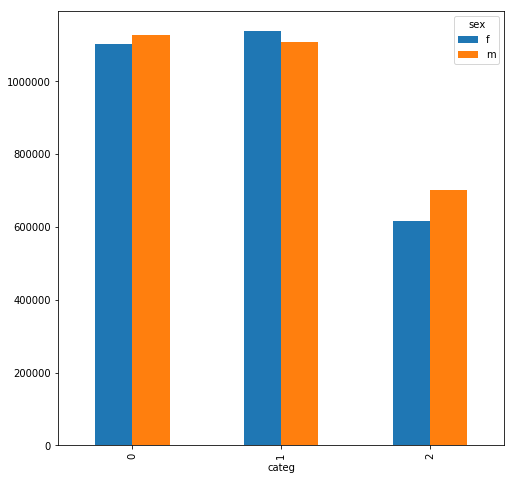

In [79]:
df_revbysexe.plot(kind="bar",figsize=(8,8),stacked=False)

# Dépenses par catégrie de produit selon l'âge des clients

In [80]:
# on crée la table nécessaire
df_revbyage=df_revenues_c.groupby(['age','categ'])['price'].sum().reset_index()
df_revbyage.rename(columns={'price':'expenses'}, inplace=True)
df_revbyage.head()

,age,categ,expenses
0,18,0,17619.77
1,18,1,56924.91
2,18,2,220843.30
3,19,0,5199.48
4,19,1,16772.25


In [81]:
# On crée des catégories selon les ages afin d'estimer la part des revenues
df_revbyage['age category'] = pd.cut(df_revbyage['age'], [17,25,35,45,55,94], labels=['<25','25-35','35-45','45-55','>55'])
df_revbyage_tot=df_revbyage.groupby(['age category'])['expenses'].sum().reset_index()
df_revbyage_tot.sort_values(by=['age category']).head()

,age category,expenses
0,<25,1064825.07
1,25-35,1156227.61
2,35-45,1539257.35
3,45-55,1056932.22
4,>55,980543.71


In [82]:
# on regarde le détail des dépenses par catégories de produits
df_revbyage_catp=df_revbyage.groupby(['age category','categ'])['expenses'].sum().reset_index()
df_revbyage_catp=df_revbyage_catp.pivot_table(index='age category', columns='categ', values='expenses', fill_value=0)
df_revbyage_catp=df_revbyage_catp.reset_index()
df_revbyage_catp=df_revbyage_catp.set_index('age category')
df_revbyage_catp

categ,0,1,2
age category,,,
<25,57608.37,194978.75,812237.95
25-35,425159.03,319772.78,411295.80
35-45,968213.19,546891.52,24152.64
45-55,500523.24,521715.12,34693.86
>55,279427.01,664026.24,37090.46


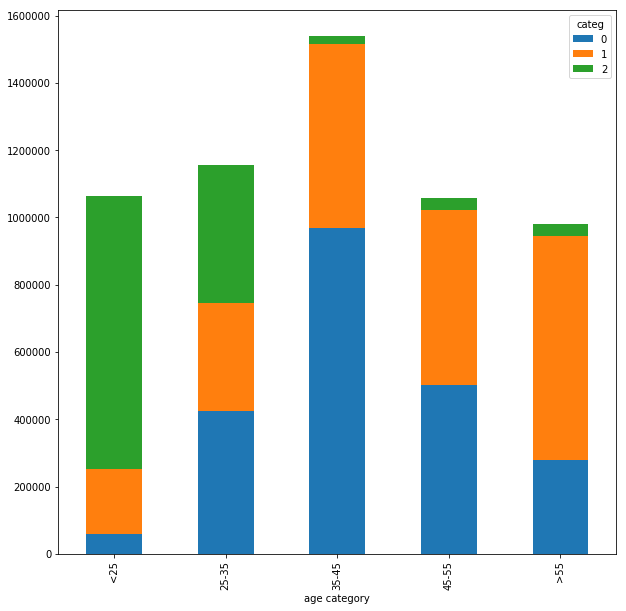

In [83]:
# on fait le graph en question
df_revbyage_catp.plot(kind="bar",figsize=(10,10),stacked=True)

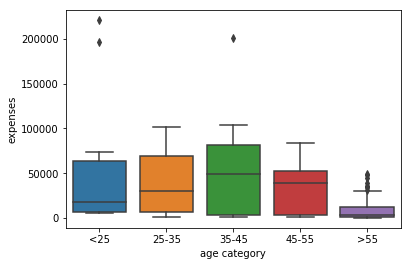

In [84]:
Boxp = sns.boxplot(x="age category", y="expenses", data=df_revbyage)

# Mission n°3

# Correlation en le sexe et la catégorie de produit acheté

In [85]:
df_revenues_for_c=df_revenues_c[(df_revenues_c['month']!='10')]
df_revenues_for_c=df_revenues_for_c[(df_revenues_for_c['age']!=18)]
df_revenues_for_c=df_revenues_for_c[(df_revenues_for_c['client_id']!=3454|6714|4958|1609)]

In [86]:
# Contingency table
X = "sex"
Y = "categ"

frequency_table = df_revenues_for_c[[X, Y]].pivot_table(
    index=X, columns=Y, aggfunc=len)  # The frequency table without total
cont = frequency_table.copy()

# We count the number of men and women
tx = df_revenues_for_c[X].value_counts()
# We count the number of transactions in categ 0, 1, 2
ty = df_revenues_for_c[Y].value_counts()

# We add the totals
cont.loc[:, "Total"] = tx
cont.loc["total",:]  = ty
cont.loc["total", "Total"] = len(df_revenues_c)
cont

categ,0,1,2,Total
sex,,,,
f,93863.0,53265.0,6309.0,153437.0
m,95374.0,52093.0,7358.0,154825.0
total,189237.0,105358.0,13667.0,336816.0


In [87]:
# We calculate the values.
tx = pd.DataFrame(tx)
ty = pd.DataFrame(ty)
tx.columns = ["foo"]
ty.columns = ["foo"]
n = len(df_revenues_for_c)
indep = tx.dot(ty.T) / n  # Table if the sex does not play a role, HO True.
mesure = (frequency_table-indep)**2/indep  # mesurecontains the X² by cell.
X2STAT = mesure.sum().sum()  # Value X²
# p_value
# Probability than the test statistic is equal or more extreme than the sample result, given H0 True.
p_value = scipy.stats.chi2.sf(X2STAT, df=2)
p_value

2.643312713717522e-22

In [88]:
indep

,0,1,2
m,95044.535249,52916.195801,6864.26895
f,94192.464751,52441.804199,6802.73105


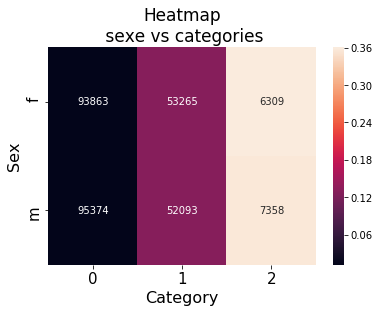

In [89]:
# heat map
f, ax = plt.subplots()
sns_plot = sns.heatmap(mesure/X2STAT, annot=frequency_table, fmt='g')

# Titre
titre = "Heatmap\n sexe vs categories"
title = plt.title(titre, fontsize=17)

# Labels
ax.set_ylabel('Sex', fontsize=16)
ax.set_xlabel('Category', fontsize=16)

# Ticks
ax.tick_params(labelsize=15)

plt.show()

# Correlation en l'age et le montant total dépensé

In [90]:
# on regarde le coefficient de correlation
df_revenues_for_c[['age', 'price']].corr()

,age,price
age,1.000000,-0.174071
price,-0.174071,1.000000


In [91]:
# On va utiliser statsmodels
Y = df_revenues_for_c["price"]
X = df_revenues_for_c[["age"]]
X1 = X.copy()

X1["intercept"] = 1.
results = sm.OLS(Y, X1).fit()
a1, b1 = results.params["age"], results.params["intercept"]
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     9632.
Date:                Thu, 08 Nov 2018   Prob (F-statistic):               0.00
Time:                        17:36:39   Log-Likelihood:            -1.3020e+06
No. Observations:              308262   AIC:                         2.604e+06
Df Residuals:                  308260   BIC:                         2.604e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age           -0.2218      0.002    -98.144      0.0

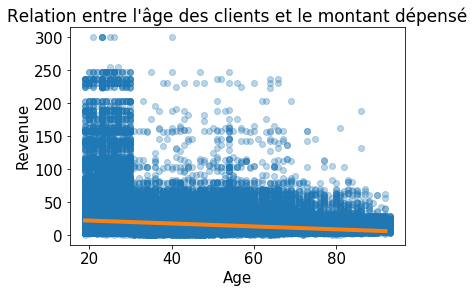

In [92]:
# On défini le max et le min de la régression
min_model = min(df_revenues_for_c.age)
max_model = max(df_revenues_for_c.age)

# On fait le scatterplot
plt.plot(df_revenues_for_c.age, df_revenues_for_c.price, "o", alpha=0.3)

# on ajoute la droite de régression linéaire
plt.plot(np.arange(min_model, max_model), [
         a1*x+b1 for x in np.arange(min_model, max_model)], linewidth=4)

# Labels
label = plt.xlabel("Age", fontsize=15)
label = plt.ylabel("Revenue", fontsize=15)
plt.tick_params(labelsize=15)


titre = "Relation entre l'âge des clients et le montant dépensé"
title = plt.title(titre, fontsize=17)

# Correlation en l'age et le nombre d'achats (par mois)

In [93]:
frequency = df_revenues_for_c.copy()
frequency["frequency"] = 1
# On groupe par client et par age par mois
frequency = frequency.groupby(["client_id", "age", "month"])[
    ["frequency"]].sum()
frequency.reset_index(inplace=True)
# We group by client_id and calculate the average purchasing frequency.
# There are 12 months.
frequency = frequency.groupby(["client_id", "age"])["frequency"].sum()
frequency = frequency.reset_index()
# We divide by 12 to obtain the frequency by months.
frequency.frequency = frequency.frequency/12
# We order by frequency
frequency=frequency[(frequency['frequency']<16)]
frequency.sort_values(inplace=True, by="frequency", ascending=False)

In [94]:
frequency.head()

,client_id,age,frequency
7397,8026,44,15.333333
1686,2595,48,14.916667
6768,7421,44,14.833333
5192,5922,45,14.750000
2389,3263,37,14.750000


In [95]:
Y = frequency["frequency"]
X = frequency[["age"]]
X1 = X.copy()

X1["intercept"] = 1.
# Fit regression model
results = sm.OLS(Y, X1).fit()
# Inspect the results
print(results.summary())
# Save the results to then draw the model
a2, b2 = results.params["age"], results.params["intercept"]

                            OLS Regression Results                            
Dep. Variable:              frequency   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.463
Date:                Thu, 08 Nov 2018   Prob (F-statistic):              0.226
Time:                        17:36:41   Log-Likelihood:                -19487.
No. Observations:                8157   AIC:                         3.898e+04
Df Residuals:                    8155   BIC:                         3.899e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age           -0.0022      0.002     -1.210      0.2

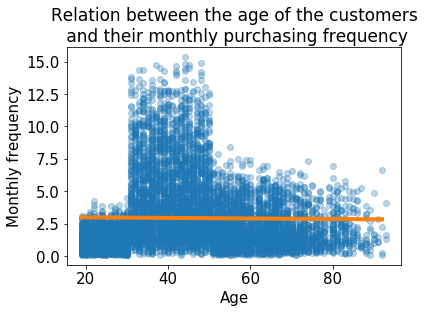

In [96]:
# Use statsmodels.api
# We plot the scatter plot
plt.plot(frequency.age, frequency.frequency, "o", alpha=0.3)

# We draw the liner regression model
plt.plot(np.arange(min_model, max_model), [
         a2*x+b2 for x in np.arange(min_model, max_model)], linewidth=4)

# Labels
label = plt.xlabel("Age", fontsize=15)
label = plt.ylabel("Monthly frequency", fontsize=15)
plt.tick_params(labelsize=15)

# We define the title of the axes.
titre = "Relation between the age of the customers\n and their monthly purchasing frequency"
title = plt.title(titre, fontsize=17)

In [97]:
frequency30=frequency[(frequency['age']>30)]

In [98]:
Y = frequency30["frequency"]
X = frequency30[["age"]]
X1 = X.copy()

X1["intercept"] = 1.
# Fit regression model
results = sm.OLS(Y, X1).fit()
# Inspect the results
print(results.summary())
# Save the results to then draw the model
a2, b2 = results.params["age"], results.params["intercept"]

                            OLS Regression Results                            
Dep. Variable:              frequency   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     938.0
Date:                Thu, 08 Nov 2018   Prob (F-statistic):          3.27e-192
Time:                        17:36:42   Log-Likelihood:                -15021.
No. Observations:                6328   AIC:                         3.005e+04
Df Residuals:                    6326   BIC:                         3.006e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age           -0.0742      0.002    -30.627      0.0

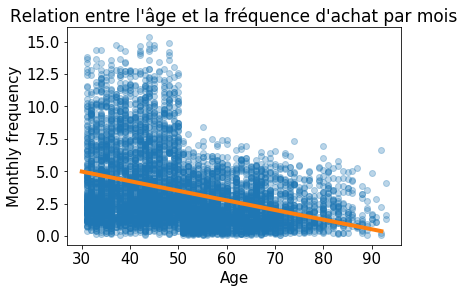

In [99]:
# Use statsmodels.api
# We plot the scatter plot
plt.plot(frequency30.age, frequency30.frequency, "o", alpha=0.3)

# We draw the liner regression model
plt.plot(np.arange(30, 93), [
         a2*x+b2 for x in np.arange(30, 93)], linewidth=4)

# Labels
label = plt.xlabel("Age", fontsize=15)
label = plt.ylabel("Monthly frequency", fontsize=15)
plt.tick_params(labelsize=15)

# We define the title of the axes.
titre = "Relation entre l'âge et la fréquence d'achat par mois"
title = plt.title(titre, fontsize=17)

# Correlation en l'age et la catégorie de produit achetée

In [100]:
age_categ = df_revenues_for_c.copy()
age_categ = age_categ.loc[:, [
    "client_id", "age", "categ"]]
age_categ.sort_values(by="client_id", inplace=True)
age_categ.reset_index(inplace=True, drop=True)

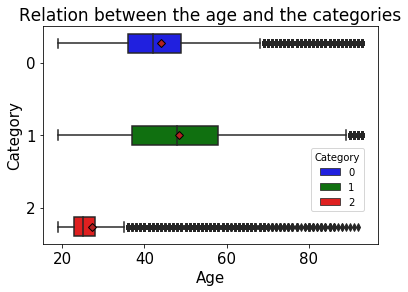

In [101]:
fig = plt.figure()
# To customize the mean.
meanpointprops = dict(marker='D', markeredgecolor='black',
                      markerfacecolor='firebrick')

ax = sns.boxplot(x="age", y="categ", hue="categ", data=age_categ,
                 orient="h", showmeans=True, meanprops=meanpointprops, palette=["b","g","r"])
plt.legend(title='Category', loc=(0.8, 0.15))

# Axis
ax.set_xlabel("Age", fontsize=15)
ax.set_ylabel("Category", fontsize=15)

ax.tick_params(labelsize=15)


# We define the title of the axes.
titre = "Relation between the age and the categories"
title = plt.title(titre, fontsize=17)

In [102]:
# We remove the outliers by looking at the age and product they buy.
age_categ_out = age_categ.copy()
std0 = age_categ_out[age_categ_out["categ"] == 0]["age"].std()
mean0 = age_categ_out[age_categ_out["categ"] == 0]["age"].mean()
std1 = age_categ_out[age_categ_out["categ"] == 1]["age"].std()
mean1 = age_categ_out[age_categ_out["categ"] == 1]["age"].mean()
std2 = age_categ_out[age_categ_out["categ"] == 2]["age"].std()
mean2 = age_categ_out[age_categ_out["categ"] == 2]["age"].mean()

# We calculate the standardized value.
age_categ_out["standardized"] = 0
age_categ_out.at[age_categ_out["categ"] == 0, "standardized"] = (
    age_categ_out[age_categ_out["categ"] == 0].loc[:, "age"]-mean0)/std0
age_categ_out.at[age_categ_out["categ"] == 1, "standardized"] = (
   age_categ_out[age_categ_out["categ"] == 1].loc[:, "age"]-mean1)/std1
age_categ_out.at[age_categ_out["categ"] == 2, "standardized"] = (
    age_categ_out[age_categ_out["categ"] == 2].loc[:, "age"]-mean2)/std2
# We rank the row according to this value
age_categ_out.sort_values(
    by="standardized", ascending=False, inplace=True)
# We excluded the value that are below or above 3 standard deviation.
# 336816 products bought, 3581 exclude.
age_categ_out = age_categ_out[(
    age_categ_out["standardized"] >= -3) & (age_categ_out["standardized"] <= 3)]

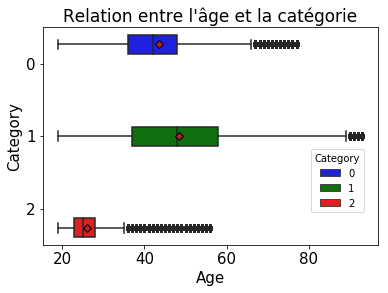

In [103]:
fig = plt.figure()
# To customize the mean.
meanpointprops = dict(marker='D', markeredgecolor='black',
                      markerfacecolor='firebrick')

ax = sns.boxplot(x="age", y="categ", hue="categ", data=age_categ_out,
                 orient="h", showmeans=True, meanprops=meanpointprops, palette=["b","g","r"])
plt.legend(title='Category', loc=(0.8, 0.15))

# Axis
ax.set_xlabel("Age", fontsize=15)
ax.set_ylabel("Category", fontsize=15)

ax.tick_params(labelsize=15)


# We define the title of the axes.
titre = "Relation entre l'âge et la catégorie"
title = plt.title(titre, fontsize=17)

In [104]:
# On fait une ANOVA car on regarde la correlation entre une variable qualitative et une variable quantitative
mod = statsmodels.formula.api.ols(
    'age ~ C(categ, Sum)', data=age_categ_out).fit()
aov_table = sm.stats.anova_lm(mod, typ=1)
print(aov_table)

                     df        sum_sq       mean_sq             F  PR(>F)
C(categ, Sum)       2.0  6.348282e+06  3.174141e+06  22636.071009     0.0
Residual       305046.0  4.277505e+07  1.402249e+02           NaN     NaN


In [105]:
value_eta_squared = aov_table['sum_sq'][0] / \
    (aov_table['sum_sq'][0]+aov_table['sum_sq'][1])
FSTAT = aov_table['F'][0]
pvalue = aov_table['PR(>F)'][0]
print("Correlation Report = {}, FSTAT = {}, pvalue = {}".format(
    round(value_eta_squared, 2),
    round(FSTAT, 2),
    round(pvalue, 2)))
print("We reject H0.")

Correlation Report = 0.13, FSTAT = 22636.07, pvalue = 0.0
We reject H0.


In [110]:
age_categ_out

,client_id,age,categ,standardized
151693,477,77,0,2.987005
35343,1633,77,0,2.987005
64379,2411,77,0,2.987005
271610,7771,77,0,2.987005
280551,799,77,0,2.987005
151701,477,77,0,2.987005
35344,1633,77,0,2.987005
64384,2411,77,0,2.987005
183066,5550,77,0,2.987005
108959,3563,77,0,2.987005


# Corrélation entre l'âge et la taille du panier

In [106]:
basket = df_revenues_for_c
basket["nb_products"] = 1  
# On groupe par cleint et par age
basket = basket.groupby(["client_id", "age", "session_id"])[
    ["nb_products"]].sum()
# On ajoute une colonne pour calculer le nombre de session
basket["nb_sessions"] = 1
basket = basket.groupby(["client_id", "age"])[
    ["nb_products", "nb_sessions"]].sum()
basket.reset_index(inplace=True)
# On calcule maintenant le panier moyen
basket["average_nb_products"] = basket["nb_products"]/basket["nb_sessions"]

In [107]:
basket.head()

,client_id,age,nb_products,nb_sessions,average_nb_products
0,1,67,19,14,1.357143
1,10,66,28,16,1.750000
2,100,30,6,3,2.000000
3,1000,56,53,40,1.325000
4,1001,40,52,21,2.476190


In [108]:
Y = basket["average_nb_products"]
X = basket[["age"]]
X1 = X.copy()

X1["intercept"] = 1
# Fit regression model
results = sm.OLS(Y, X1).fit()
# Inspect the results
print(results.summary())
# Save the results to then draw the model
a3, b3 = results.params["age"], results.params["intercept"]

                             OLS Regression Results                            
Dep. Variable:     average_nb_products   R-squared:                       0.071
Model:                             OLS   Adj. R-squared:                  0.070
Method:                  Least Squares   F-statistic:                     619.6
Date:                 Thu, 08 Nov 2018   Prob (F-statistic):          7.06e-132
Time:                         17:36:47   Log-Likelihood:                -7877.1
No. Observations:                 8161   AIC:                         1.576e+04
Df Residuals:                     8159   BIC:                         1.577e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age           -0.0108      0.000    -24.89

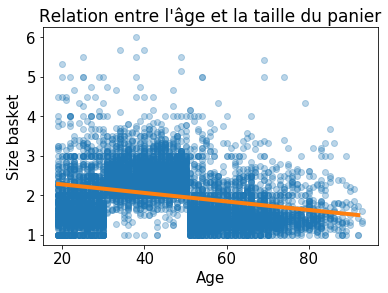

In [109]:
# Use statsmodels.api
# We plot the scatter plot
plt.plot(basket.age, basket.average_nb_products, "o", alpha=0.3)

# We draw the liner regression model
plt.plot(np.arange(min_model, max_model), [
         a3*x+b3 for x in np.arange(min_model, max_model)], linewidth=4)

# Labels
label = plt.xlabel("Age", fontsize=15)
label = plt.ylabel("Size basket", fontsize=15)
plt.tick_params(labelsize=15)
# We define the title of the axes.
titre = "Relation entre l'âge et la taille du panier"
title = plt.title(titre, fontsize=17)


# We save the figure
plt.savefig('relation_age_size_basket.png')